In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,18,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,9)],sheet_name='round2').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,7]

X_norm = x_normalizer(X)
ss_y = 0.003
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


In [5]:
data

,Tip Height \n(mm) 0.5-50,Dispense Speed \n(ul/s) 20-500,AS Spin Speed \n(rpm) 500-7000,AS Volume \n(ul) 50-300,Timing AS\n (s) 2-18,PL Intensity ave,PL Intensity CV,Peak CV
0,1.5,90.0,5600.0,50.0,12.0,175357.061097,0.173763,0.001152
1,20.0,460.0,2300.0,220.0,25.0,178837.692437,0.309365,0.001924
2,4.0,250.0,7000.0,300.0,22.0,324724.062188,0.119376,0.000455
3,8.0,260.0,4900.0,100.0,5.0,251923.044783,0.227518,0.000707
4,15.5,170.0,5100.0,70.0,7.0,228986.076923,0.144984,0.000439
5,29.5,380.0,5800.0,100.0,13.0,241866.564743,0.123097,0.001060
6,32.0,450.0,800.0,140.0,15.0,188744.000000,0.099226,0.000456
7,50.0,200.0,1700.0,110.0,6.0,245398.692308,0.099245,0.000540
9,30.0,170.0,500.0,250.0,2.0,334861.307692,0.033553,0.000208
10,27.5,440.0,7000.0,290.0,2.0,367440.769231,0.060029,0.000383


In [6]:
Train_X

array([[0.07070707, 0.47916667, 1.        , 1.        , 1.25      ],
       [0.83838384, 0.875     , 0.64615385, 0.96      , 0.9375    ],
       [0.63636364, 0.89583333, 0.04615385, 0.36      , 0.8125    ],
       [1.        , 0.375     , 0.18461538, 0.24      , 0.25      ],
       [0.45454545, 0.        , 0.        , 1.        , 0.9375    ],
       [0.39393939, 0.91666667, 0.27692308, 0.68      , 1.4375    ],
       [0.46464646, 0.14583333, 0.2       , 0.8       , 0.1875    ],
       [0.02020202, 0.14583333, 0.78461538, 0.        , 0.625     ],
       [1.        , 0.        , 0.        , 0.04      , 0.375     ],
       [0.        , 0.        , 1.        , 1.        , 0.        ],
       [0.47474747, 0.125     , 0.04615385, 1.        , 0.875     ],
       [0.54545455, 0.875     , 1.        , 0.96      , 0.        ],
       [0.5959596 , 0.3125    , 0.        , 0.8       , 0.        ],
       [0.11111111, 0.47916667, 0.03076923, 1.        , 1.375     ],
       [1.        , 0.33333333, 0.

In [19]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)
#poly = GPy.kern.Poly(input_dim=5)
kernel = m52
model_gpy = GPy.models.GPRegression(Train_X,Train_y.reshape(-1,1),kernel)

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts = 50)
model_gpy.optimize(messages=True)

y_pred_train = model_gpy.predict(Train_X)[0].ravel()
y_pred_test = model_gpy.predict(Test_X)[0].ravel()
var_train = np.sqrt(model_gpy.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model_gpy.predict(Test_X)[1]).ravel()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = -4.799953286604191
Optimization restart 2/50, f = -4.799955008582298
Optimization restart 3/50, f = -4.799952958097865
Optimization restart 4/50, f = -4.799944654743887
Optimization restart 5/50, f = -4.799954361026229
Optimization restart 6/50, f = -4.799953969655442
Optimization restart 7/50, f = -4.799954783038287
Optimization restart 8/50, f = -4.79994672674803
Optimization restart 9/50, f = -4.799953847842673
Optimization restart 10/50, f = -4.79994947191163
Optimization restart 11/50, f = -4.799953761801868
Optimization restart 12/50, f = -4.799930112897455
Optimization restart 13/50, f = -4.799940793584406
Optimization restart 14/50, f = -4.799950492605864
Optimization restart 15/50, f = -4.79995263744167
Optimization restart 16/50, f = -4.799954805851171
Optimization restart 17/50, f = -4.799954727362057
Optimization restart 18/50, f = -4.799948408369737
Optimization restart 19/50, f = -4.79995355298583
Optimization restart 20/50, f = -4.799955033

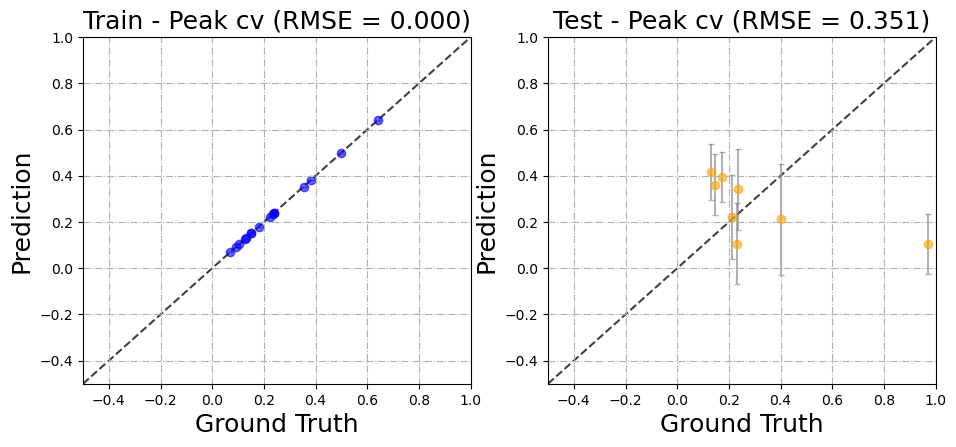

In [20]:
myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-0.5,1])
#plt.savefig('result',dpi=1000)

In [21]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,7]/ss_y
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)
kernel = m52
model = GPy.models.GPRegression(X_normalize,Y_normalize.reshape(-1,1),kernel)



model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 1.5841274080933712
Optimization restart 2/50, f = 2.5385383171876974
Optimization restart 3/50, f = 1.5841274436770458
Optimization restart 4/50, f = 2.5385366329380012
Optimization restart 5/50, f = 2.538537990237989
Optimization restart 6/50, f = 2.538536631979156
Optimization restart 7/50, f = 1.5841289575968673
Optimization restart 8/50, f = 2.5385358060097793
Optimization restart 9/50, f = 2.5385376205057852
Optimization restart 10/50, f = 2.538535743340148
Optimization restart 11/50, f = 2.5385397291408953
Optimization restart 12/50, f = 2.5385409062808186
Optimization restart 13/50, f = 2.538535829034924
Optimization restart 14/50, f = 2.5385363656399935
Optimization restart 15/50, f = 2.5385388254121892
Optimization restart 16/50, f = 2.538535748648945
Optimization restart 17/50, f = 2.5385366958406426
Optimization restart 18/50, f = 1.584127477710041
Optimization restart 19/50, f = 6.664450468086372
Optimization restart 20/50, f = 2.5385357763325

4.739949084518644e-08


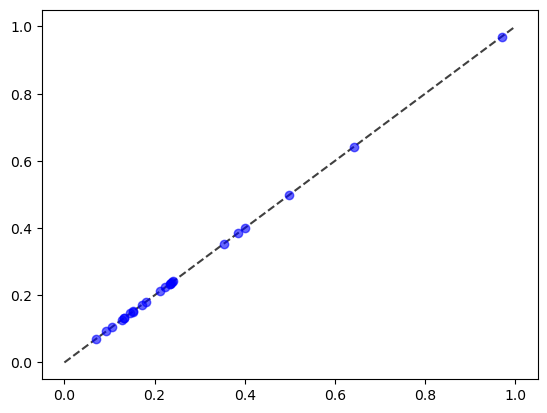

In [22]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [23]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.03125, 1.03125)]

In [24]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 3


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final


1000000
LPP


 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.46538428 0.14174281 0.2063762  0.79678339 0.13500668]
opt point :  (array([[0.46538428, 0.14174281, 0.2063762 , 0.79678339, 0.13500668]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.40654548 0.65710037 0.76375203 0.34645683 0.48595222]
opt point :  (array([[0.40654548, 0.65710037, 0.76375203, 0.34645683, 0.48595222]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.39293273 0.82394282 0.54611808 0.32101797 0.7137296 ]
opt point :  (array([[0.39293273, 0.82394282, 0.54611808, 0.32101797, 0.7137296 ]]), array([[nan]]))
acq_max =  [[nan]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.5,90.0,1800.0,250.0,4.0,0.000646,0.000002
1,20.5,340.0,5500.0,140.0,10.0,0.000497,0.000020
2,20.0,420.0,4000.0,130.0,13.0,0.000429,0.000047


In [25]:
final.to_excel('Peak cv2_gp.xlsx')

In [140]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [0.98866272 0.00769064 0.94966141 0.13388673 1.00554763]
opt point :  (array([[0.98866272, 0.00769064, 0.94966141, 0.13388673, 1.00554763]]), array([[-0.03513379]]))
acq_max =  [[0.03513379]]
1000000
Init point :  [0.99516578 0.04056787 0.98914401 0.00251727 1.01885415]
opt point :  (array([[0.99516578, 0.04056787, 0.98914401, 0.00251727, 1.01885415]]), array([[-0.351338]]))
acq_max =  [[0.351338]]
1000000
Init point :  [ 0.99258614  0.01107121  0.95669673 -0.00483881  0.99002956]
opt point :  (array([[ 0.99258614,  0.01107121,  0.95669673, -0.00483881,  0.99002956]]), array([[-3.51338012]]))
acq_max =  [[3.51338012]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,49.5,20.0,6700.0,80.0,25.0,3.738604e-11,0.00037
1,50.0,40.0,6900.0,50.0,25.0,3.886452e-11,0.00037
2,49.5,30.0,6700.0,50.0,25.0,3.654145e-11,0.00037


In [23]:
final.to_excel('Peak cv2_gp.xlsx')

In [141]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 3


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)



1000000


 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [ 0.98318072  0.43467212 -0.00366867 -0.01956027  0.18204272]
opt point :  (array([[ 0.98318072,  0.43467212, -0.00366867, -0.01956027,  0.18204272]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [ 7.48278738e-01  1.07487913e-01  5.49406295e-02 -8.80944821e-06
  6.36176334e-01]
opt point :  (array([[ 7.48278738e-01,  1.07487913e-01,  5.49406295e-02,
        -8.80944821e-06,  6.36176334e-01]]), array([[0.15129255]]))
acq_max =  [[-0.15129255]]
Init point :  [0.02999404 0.23583338 0.98299675 0.9315596  0.97028833]
opt point :  (array([[0.02999404, 0.23583338, 0.98299675, 0.9315596 , 0.97028833]]), array([[0.15129255]]))
acq_max =  [[-0.15129255]]


In [142]:
x = get_closest_array(x_denormalizer(X_new,var_array))

In [143]:
df_Xnew = pd.DataFrame(x, columns = x_label)
df_Xnew

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS
0,49.0,230.0,500.0,50.0,6.0
1,37.5,70.0,900.0,50.0,17.0
2,2.0,130.0,6900.0,280.0,24.0


In [144]:
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,49.0,230.0,500.0,50.0,6.0,2.804096e-03,0.000021
1,37.5,70.0,900.0,50.0,17.0,7.008489e-23,0.000300
2,2.0,130.0,6900.0,280.0,24.0,2.781154e-26,0.000300
